<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#BCS" data-toc-modified-id="BCS-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>BCS</a></span></li><li><span><a href="#Varying-V" data-toc-modified-id="Varying-V-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Varying V</a></span></li></ul></div>

# BCS

Using the Paper by [Wu et al.](https://arxiv.org/abs/quant-ph/0108110), we have that:

The BCS hamiltonian is:

$$H_{BCS} = \sum_{m=1}^N \frac{\epsilon_m}{2} ( n_m^F + n_{-m}^F ) + \sum_{m,k=1}^N V^{+}_{ml} c^\dagger_m c^\dagger_{-m} c_{-l}c_l$$

Where $n_{\pm m}^F = c^\dagger_{\pm m} c_{\pm m}$, and the matrix elements $V^+_{ml} = \langle m, -m| V | l, -l \rangle$.

Which is mapped into:

$$H_P = \sum_{m=1}^N \frac{\epsilon_m}{2} \sigma^Z_m + \sum_{r= \pm l} \sum_{l>m=1}^N \frac{V_{ml}^r}{2} ( \sigma^x_m \sigma^x_l + r \sigma^y_m \sigma^y_l )$$

where $\epsilon_m = \epsilon_m + V^+_{mm}$ and $V^-_{ml} = 0$ for the BCS Hamiltonian, thus:

$$H_P = \sum_{m=1}^N \frac{\epsilon_m}{2} \sigma^Z_m +  \sum_{l>m=1}^N \frac{V_{ml}}{2} ( \sigma^x_m \sigma^x_l +  \sigma^y_m \sigma^y_l )$$

$l \ \mathrm{and} \ m$ now denote both state and qubit indices. In this case the qubit state space $H_P = Span \{ |0 \rangle, \sigma^+_m |0 \rangle, \sigma_l^+ \sigma_m^+ |0 \rangle, \dots   \}$ is mapped into a subspace where $n_m^F = n^F_{-m}$. Considering $V_{ml} = V$, we have that:

$$
H_p = \hbar \bigg[ \sum_{m=1}^N \frac{\epsilon_m}{2} \sigma_z^m + \frac{V}{2} \sum_{l>m=1}^N (\sigma_x^m \sigma_x^l + \sigma_y^m \sigma_y^l) \bigg]
$$

This leads to a spectrum of $E_0^{\pm} = \pm(\epsilon_0 + \epsilon_1)/2$, $E_1^{\pm} = \pm \sqrt{\epsilon^2 + 4V^2}/2$, where $\epsilon^2 = (\epsilon_0 - \epsilon_1)^2$.
The eigenvalues are calculated in this [notebook](https://colab.research.google.com/drive/18IyDfCYlMx957260MSwvJtUeTcAJFnza?usp=sharing):

[Aqua Operator Flow Reference](https://github.com/dongreenberg/aqua_talks/blob/master/Understanding%20Aqua's%20Operator%20Flow.ipynb)

In [1]:
import sys
sys.path.append('../../')

# Python imports
import numpy as np
import matplotlib.pyplot as plt

# Qiskit
from qiskit import BasicAer
from qiskit.aqua.components.optimizers import COBYLA, SPSA, L_BFGS_B
from qiskit.circuit.library import TwoLocal

# VOLTA
from VOLTA.VQD import VQD
from VOLTA.utils import classical_solver
from VOLTA.Hamiltonians import BCS_hamiltonian

%load_ext autoreload
%autoreload 2

In [27]:
EPSILONS = [3, 3]
V = -2
hamiltonian = BCS_hamiltonian(EPSILONS, V)
print(hamiltonian)

SummedOp([
  1.5 * ZI,
  1.5 * IZ,
  -1.0 * XX,
  -1.0 * YY
])


In [28]:
eigenvalues, eigenvectors = classical_solver(hamiltonian)
print(f"Eigenvalues: {eigenvalues}")

Eigenvalues: [-3. -2.  2.  3.]


# Varying V

In [99]:
from tqdm import tqdm

def hamiltonian_varying_V(min_V, max_V, points, epsilons):
    energies_VQD = []
    energies_Classical = []
    
    V = np.linspace(min_V, max_V, points)
    
    for v in tqdm(V):
        hamiltonian = BCS_hamiltonian(epsilons, v)
        
        backend = QuantumInstance(backend=BasicAer.get_backend('qasm_simulator'),
                              shots=10000)

        # Define ansatz
        ansatz = TwoLocal(hamiltonian.num_qubits, ['ry','rz'], 'cx', reps=2)

        # Run algorithm
        Algo = VQD(hamiltonian=hamiltonian,
                    ansatz=ansatz,
                    n_excited_states=2,
                    beta=10.,
                    optimizer=optimizer,
                    backend=backend)
        
        Algo.run(0)      
        quantum = Algo.energies
        energies_VQD.append([quantum[1], quantum[2]])
        classical, _ = classical_solver(hamiltonian)
        energies_Classical.append([classical[1], classical[2]])
    
    return energies_VQD, energies_Classical, V

In [100]:
min_V = -0.
max_V = -2.5
points = 10
epsilons = [3,3]
energy_vqd, energy_classical, V = hamiltonian_varying_V(min_V, max_V, points, epsilons)


100%|██████████| 10/10 [25:26<00:00, 152.29s/it]

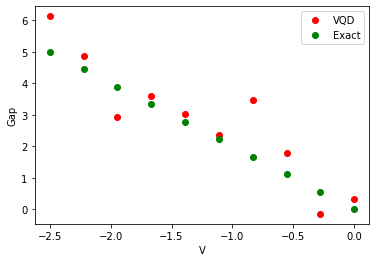

In [101]:
plt.plot(V, [value[1] - value[0] for value in energy_vqd], 'ro', label="VQD")
plt.plot(V, [value[1] - value[0] for value in energy_classical], 'go', label="Exact")
plt.xlabel('V')
plt.ylabel('Gap')
plt.legend()
plt.show()